# Determining tortuosity using geometric domain decomposition

Import necessary packages and functions

In [1]:
import numpy as np
import porespy as ps
import openpnm as op
import matplotlib.pyplot as plt
ps.visualization.set_mpl_style()

## Generate test imate

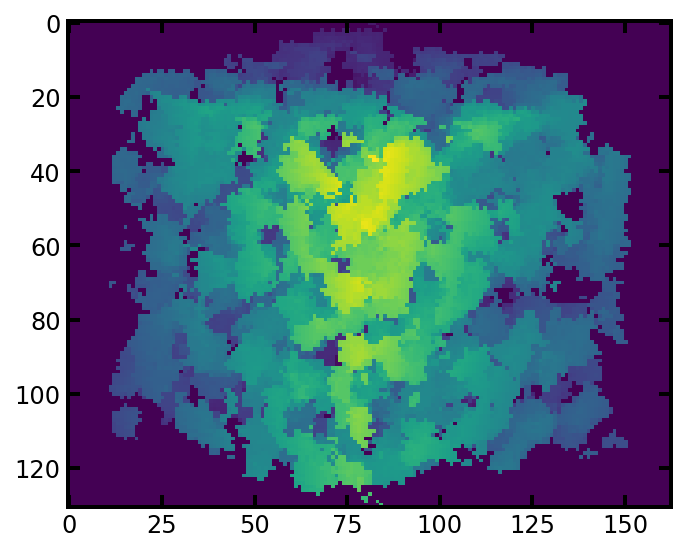

In [12]:
im = ps.generators.fractal_noise(shape=[100,100,100], seed=1)<0.8
plt.imshow(ps.visualization.show_3D(im))

## Run the function on the image

In [3]:
out = ps.simulations.tortuosity_gdd(im, scale_factor=3)
out[:3]

Max distance transform found: 13.748000144958496
[2 2 2] <= [3,3,3], using 33 as chunk size.


[1.2961143969870055, 1.3122772630635762, 1.2765576174255389]

The first three results in the returned object are the tortuosity values in the x, y, and z-direction respectively. However, there is a more useful form of this function.

In [4]:
out2 = ps.simulations.chunks_to_dataframe(im, scale_factor=3)
out2.iloc[:10,:]

Max distance transform found: 13.748000144958496
[2 2 2] <= [3,3,3], using 33 as chunk size.


,Throat Number,Tortuosity,Diffusive Conductance,Porosity
0,0,1.255869,21.036947,0.800595
1,1,1.264221,20.170891,0.772741
2,2,1.315256,19.641653,0.782842
3,3,1.217459,21.375559,0.788602
4,4,1.311078,19.646803,0.780560
5,5,1.224430,22.203311,0.823831
6,6,1.235231,21.937054,0.821131
7,7,1.328601,18.603903,0.749005
8,8,1.250015,19.841821,0.751593
9,9,1.316883,18.879632,0.753402


The ``chunks_to_dataframe`` function returns a DataFrame containing the tortuosity, diffusive conductance, and porosity values of each slice, which can be used to obtain the previous results from OpenPNM.

Assign the diffusive conductance values to the network and run the simulation.

In [5]:
net = op.network.Cubic([3,3,3])
air = op.phase.Phase(network=net)

air['throat.diffusive_conductance']=np.array(out2.iloc[:,2]).flatten()

fd=op.algorithms.FickianDiffusion(network=net, phase=air)
fd.set_value_BC(pores=net.pores('left'), values=1)
fd.set_value_BC(pores=net.pores('right'), values=0)
fd.run()

rate_inlet = fd.rate(pores=net.pores('left'))[0]

# the length of one slice is removed from the total length since the network edge begins
# in the center of the first slice and ends in the center of the last slice, so the image
# length is decreased
L = im.shape[1] - 33
A = im.shape[0] * im.shape[2]
d_eff = rate_inlet * L /(A * (1-0))

e = im.sum() / im.size
D_AB = 1

tau_gdd = e * D_AB / d_eff

tau_gdd


1.2961143969870055

In [6]:
direct = ps.simulations.tortuosity_fd(im, 0)
tau_direct = direct.tortuosity
tau_direct

1.279930256188868

The tortuosity distribution can be found from the dataframe.

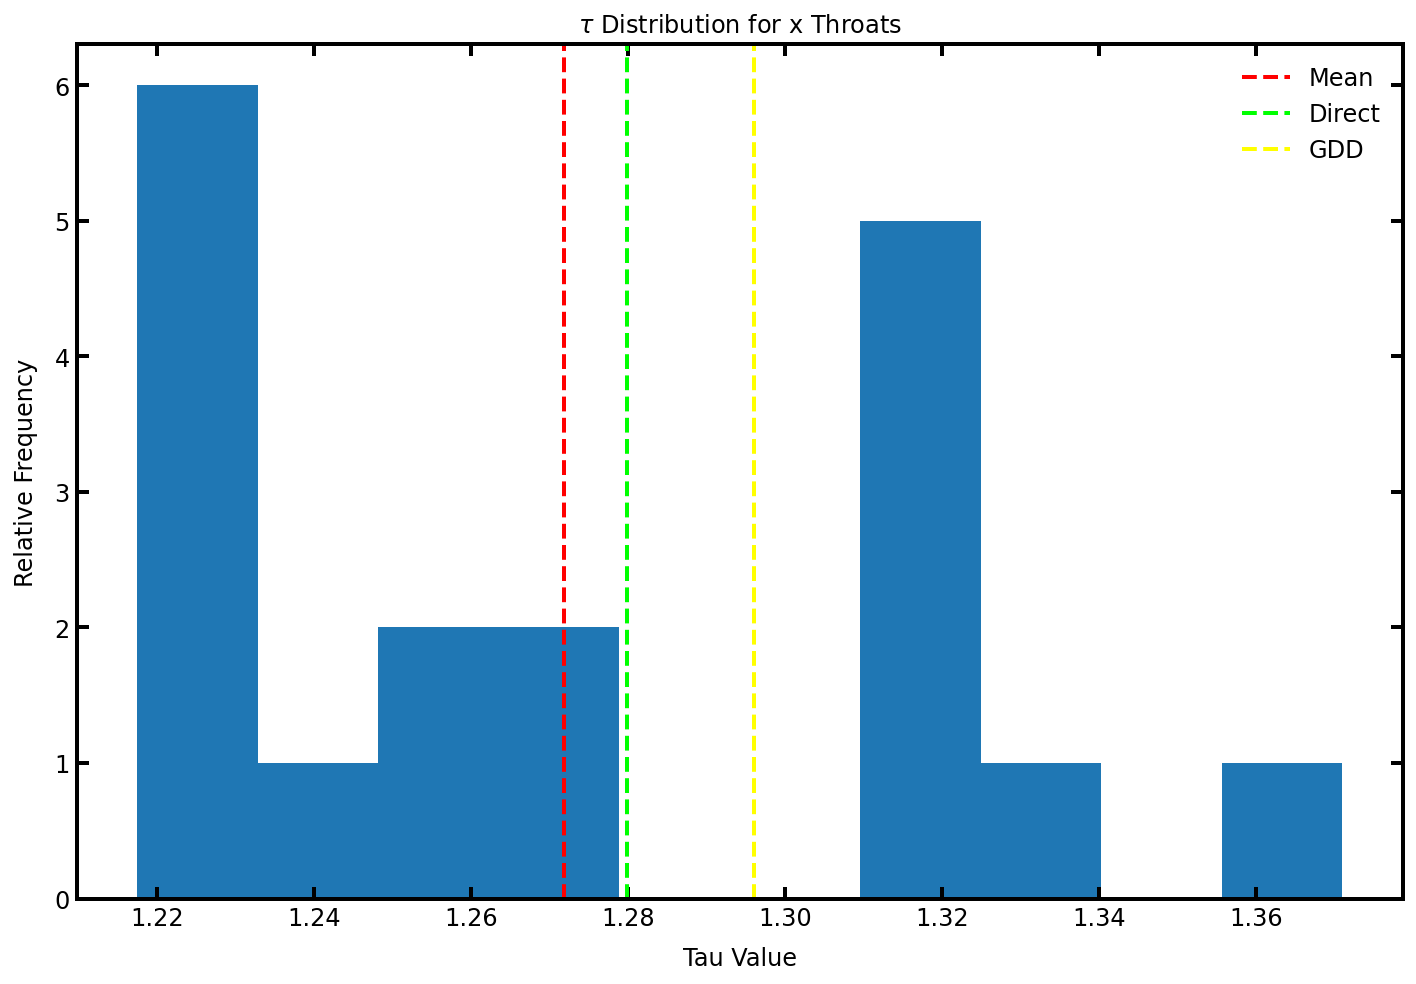

In [10]:
tau_values = np.array(out2.iloc[:, 1])
# the array of tau values is split up into thirds, where each third describes the throats in
# orthogonal directions of x, y, and z

fig, ax = plt.subplots(figsize=[10,7])
ax.set_title(r"$\tau$ Distribution for x Throats")
ax.hist(tau_values[:len(tau_values)//3])
ax.axvline(np.mean(tau_values[:len(tau_values)//3]), color='red', label='Mean', linestyle='--')
ax.axvline(tau_direct, color='lime', label='Direct', linestyle='--')
ax.axvline(tau_gdd, color='yellow', label='GDD', linestyle='--')

ax.set_xlabel(r'Tau Value')
ax.set_ylabel(r'Relative Frequency')
ax.legend()

